In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression, ElasticNet, ElasticNetCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint

### 1: Cost functions for classification trees:
#### Gini index, (mis)classification error, and cross-entropy(deviance) in simple classification settings with two classes 

-  The Gini index and cross-entropy are suitable for growing trees. Unlike the classification error, the Gini index and cross-entropy are differentiable and thus more amenable to numerical optimization. Also importantly, they are more sensitive to changes in the node probabilities than the classification error.
<br>

- For pruning a decision tree, classification error is generally used. More speficially, the classification error is used when the goal is to maximize loss function such as classification accuracy. Intuitively, it would be more effective to refer to a metric that is directly related to maximizing corresponding loss function. That is, if the loss functions are based on Brier score or log-loss, the Gini index and cross-entropy are suitable respectively. In addition, when the tree algorithm is greedy, referring to the classification accuracy at each step is not preferable, as classification errror is not as sensitive and thus is likely to overfit to noises. 

### 2: Estimate the models:
#### predicting `colarc` using the training set with 10-fold CV: 
- Logistic regression 
- Naive Bayes
- Elastic Net regression 
- Decision tree (CART)
- Bagging
- Random forest
- Boosting 

#### Tune the relevant hyperparameters for each model as necessary. Only use the tuned model with the best performance for the remaining exercises. 
<br>


In [2]:
train = pd.read_csv('data/gss_train.csv')
test = pd.read_csv('data/gss_test.csv')

#train.info()
#test.info()

test.head()

,age,attend,authoritarianism,black,born,childs,colath,colrac,colcom,colmil,...,partyid_3_Ind,partyid_3_Rep,relig_CATHOLIC,relig_NONE,relig_other,social_cons3_Mod,social_cons3_Conserv,spend3_Mod,spend3_Liberal,zodiac_other
0,22,2,1,0,0,0,0,1,1,1,...,1,0,1,0,0,0,0,0,0,1
1,49,0,4,0,0,2,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,50,0,3,0,0,2,1,1,0,1,...,0,0,0,0,0,0,0,0,1,1
3,55,4,3,0,1,6,1,1,1,1,...,0,0,1,0,0,1,0,1,0,1
4,22,3,4,0,0,0,1,1,0,1,...,0,1,0,0,0,1,0,1,0,1


In [3]:
x_train = train.drop(columns = 'colrac')
x_test = test.drop(columns = 'colrac')
y_train = train['colrac']
y_test = test['colrac']

- I use the `RandomizedSearchCV` instead of the `GridSearchCV` for computational efficiency.
<br>
- I was not entirely sure about which and within what range hyperparameters needed to be searched , so irrespective of characteristics of models, there are some logical inconherence in my selection and search of hyperparameters... 

#### 1. Logistic regression

In [4]:
# adapted from https://www.geeksforgeeks.org/ml-hyperparameter-tuning/
    
# Creating the hyperparameter grid 
c_space = np.logspace(-5, 8, 15) 
param_grid = {'C': c_space} 
  
# Instantiating logistic regression classifier 
logreg = LogisticRegression() 
  
# Instantiating the GridSearchCV object 
logreg_cv = RandomizedSearchCV(logreg, param_grid, cv = 5) 
  
logreg_cv.fit(x_train, y_train) 
  
# Print the tuned parameters and score 
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))  
print("Best score is {}".format(logreg_cv.best_score_)) 

Tuned Logistic Regression Parameters: {'C': 0.4393970560760795}
Best score is 0.7953929539295393


#### 2. Naive Bayes

In [5]:
nb =  GaussianNB()

#### 3. Elastic Net regression

In [6]:
en = ElasticNetCV (cv = 10).fit(x_train, y_train)
print('The best alpha:', en.alpha_)
print ('The best l1 ratio:', en.l1_ratio)

The best alpha: 0.0038452641680228584
The best l1 ratio: 0.5


In [7]:
# tuned 
eNet = ElasticNet(alpha = 0.0038452641680228584, l1_ratio = 0.5)

#### 4. Decision tree (CART)

In [8]:
# adapted from: https://www.geeksforgeeks.org/ml-hyperparameter-tuning/

# Creating the hyperparameter grid  
param_dist = {"max_depth": randint(1,10), 
              "criterion": ["gini", "entropy"]} 
  
# Instantiating Decision Tree classifier 
tree = DecisionTreeClassifier() 
  
# Instantiating RandomizedSearchCV object 
tree_cv = RandomizedSearchCV(tree, param_dist, cv = 10) 
  
tree_cv.fit(x_train, y_train) 
  
# Print the tuned parameters
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_)) 

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 4}


In [9]:
# tuned
dt = tree_cv.best_estimator_

#### 5. Bagging

In [10]:
bg = BaggingClassifier()

In [11]:
bg.get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [12]:
n_estimators = range(20,100)

bg_grid = {'n_estimators': n_estimators}

In [13]:
bg_random = RandomizedSearchCV(estimator = bg, param_distributions = bg_grid, cv = 10)
bg_random.fit(x_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=BaggingClassifier(base_estimator=None,
                                               bootstrap=True,
                                               bootstrap_features=False,
                                               max_features=1.0,
                                               max_samples=1.0, n_estimators=10,
                                               n_jobs=None, oob_score=False,
                                               random_state=None, verbose=0,
                                               warm_start=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'n_estimators': range(20, 100)},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [14]:
bg_random.best_params_ 

{'n_estimators': 96}

In [15]:
# tuned 
bag = bg_random.best_estimator_

In [16]:
bag

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=96,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

#### 6. Random forest

In [17]:
rf = RandomForestClassifier()

In [18]:
rf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [19]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [20]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using  fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 10)# Fit the random search model
rf_random.fit(x_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=Non

In [21]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 110,
 'bootstrap': True}

In [22]:
# tuned 
rf = rf_random.best_estimator_

In [23]:
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=110, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### 7. Boosting

In [24]:
boo = GradientBoostingClassifier()

In [25]:
boo.get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [26]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
learning_rate = [0.15,0.1,0.05,0.01,0.005,0.001]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]# Create the random grid
boo_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [27]:
# Random search of parameters, using  fold cross validation, 
# search across 100 different combinations, and use all available cores
boo_random = RandomizedSearchCV(estimator = boo, param_distributions = boo_grid, cv = 10)# Fit the random search model
boo_random.fit(x_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                    

In [28]:
# tuned 
boos = boo_random.best_estimator_

In [29]:
boos

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=32,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### 3. Compare and present each model's training performance based on: 
- cross-validated error rate
- ROC/AUC

In [30]:
logit_err = 1 - cross_val_score(LogisticRegression(solver = 'liblinear'), x_train, y_train, cv = 10).mean() # used the regularized form through liblinear

nb_err = 1 - cross_val_score(nb, x_train, y_train, cv = 10). mean()

eNet_err = -np.mean(cross_val_score(eNet, x_train, y_train, cv = 10, scoring = 'neg_mean_squared_error')) # mse 

cart_err = 1 - cross_val_score(dt, x_train, y_train, cv = 10).mean()

bag_err = 1 - cross_val_score(bag, x_train, y_train, cv = 10).mean()

rf_err = 1 - cross_val_score (rf, x_train, y_train, cv = 10).mean()

boo_err = 1 - cross_val_score(boos, x_train, y_train, cv = 10).mean()

In [31]:
print('cross_validated error rate for logit:', logit_err)
print('cross_validated error rate for Naive Bayes:', nb_err)
print('cross_validated error rate for eNet:', eNet_err)
print('cross_validated error rate for cart:', cart_err)
print('cross_validated error rate for bagging:', bag_err)
print('cross_validated error rate for random forest:', rf_err)
print('cross_validated error rate for gradient boosting:', boo_err)

cross_validated error rate for logit: 0.20731955760718945
cross_validated error rate for Naive Bayes: 0.26555250977590383
cross_validated error rate for eNet: 0.1471453221731916
cross_validated error rate for cart: 0.21753736684225655
cross_validated error rate for bagging: 0.21346039231945269
cross_validated error rate for random forest: 0.19852192282681247
cross_validated error rate for gradient boosting: 0.2134560426746429


Text(0.5, 1.0, 'Model Performance Comparision Based on CV Error Rate')

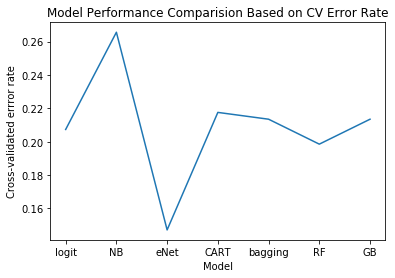

In [32]:
cv_error_rate = [logit_err,
             nb_err,
             eNet_err,
             cart_err, 
             bag_err,
             rf_err,
             boo_err]


model = ['logit',
          'NB',
          'eNet',
          'CART',
          'bagging',
          'RF',
          'GB']

plt.plot(model, cv_error_rate)
plt.xlabel('Model')
plt.ylabel('Cross-validated errror rate')
plt.title('Model Performance Comparision Based on CV Error Rate')

- Elastic Net yields the lowest cv error rate (0.15), which is noticeably smaller than the second lowest cv error rate (0.199). 

In [38]:
logit_pred = LogisticRegression(solver = 'liblinear').fit(x_train, y_train).predict(x_train)
logit_auc = roc_auc_score(logit_pred, y_train)

nb_auc = np.mean(cross_val_score(nb, x_train, y_train, scoring = 'roc_auc'))

eNet_auc = np.mean(cross_val_score(eNet, x_train, y_train, scoring = 'roc_auc'))

cart_auc = np.mean(cross_val_score(dt, x_train, y_train, scoring = 'roc_auc'))

bag_auc = np.mean(cross_val_score(bag, x_train, y_train, scoring = 'roc_auc'))

rf_auc = np.mean(cross_val_score(rf, x_train, y_train, scoring = 'roc_auc'))

boo_auc = np.mean(cross_val_score(boos, x_train, y_train, scoring = 'roc_auc'))

In [39]:
print('auc for logit:', logit_auc)
print('auc for Naive Bayes:', nb_auc)
print('auc for eNet:', eNet_auc)
print('auc for cart:', cart_auc)
print('auc for bagging:', bag_auc)
print('auc for random forest:', rf_auc)
print('auc for gradient boost:', boo_auc)

auc for logit: 0.8165964016716383
auc for Naive Bayes: 0.8097828942390941
auc for eNet: 0.865740364210058
auc for cart: 0.8354234874845714
auc for bagging: 0.8634691904354544
auc for random forest: 0.8766266658770899
auc for gradient boost: 0.8541242982388141


Text(0.5, 1.0, 'Model Performance Comparison Based on AUC')

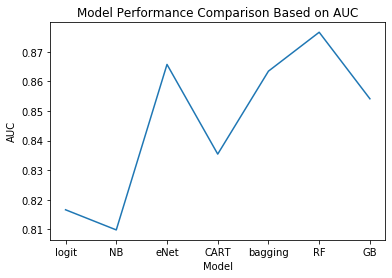

In [40]:
AUC = [logit_auc, 
      nb_auc, 
      eNet_auc, 
      cart_auc, 
      bag_auc, 
      rf_auc, 
      boo_auc]

model = ['logit',
          'NB',
          'eNet',
          'CART',
          'bagging',
          'RF',
          'GB']

plt.plot(model, AUC)
plt.xlabel('Model')
plt.ylabel('AUC')
plt.title('Model Performance Comparison Based on AUC')

- RF has the highest AUC (0.876), followed by eNet and Bagging. 

### 4. Which is the best model? Defend your choice. 

- When determining the _best_ model, AUC typically should be weighted more as it provides a general sense of model performance at all possible thresholds as opposed to the error rate, which is based on a single prior probability. 
<br>

- Thus given that RF has the highest AUC and the second lowest cv error rate, I choose the RF as the _best_ model. 

### 5. Evaluate the _final_  performance on the test set by calculating and presenting the classification error rate and AUC. Compared to the training set in questions 3-4, does the "best" model generalize well? Why or why not? How do you know? 

In [42]:
rf_test_err = 1 - accuracy_score(y_test, rf.predict(x_test))
print('RF test error:', rf_test_err)
print('RF training error:', rf_err)

rf_test_auc = roc_auc_score(y_test, rf.predict(x_test))
print('RF test AUC:', rf_test_auc)
print('RF training AUC:', rf_auc)

RF test error: 0.20081135902636915
RF training error: 0.19852192282681247
RF test AUC: 0.7911618669314797
RF training AUC: 0.8766266658770899


In [44]:
eNet_final = eNet.fit(x_train, y_train)

eNet_test_err = mean_squared_error(eNet.predict(x_test), y_test)
print('eNet test error:', eNet_test_err)
print('eNet training error:', eNet_err)

eNet_test_auc = roc_auc_score(y_test, eNet.predict(x_test))
print('eNet test AUC:', eNet_test_auc)
print('eNet training AUC:', eNet_auc)

eNet test error: 0.15457692819425847
eNet training error: 0.1471453221731916
eNet test AUC: 0.8595829195630587
eNet training AUC: 0.865740364210058


- Although both eNet and Random Forest have small test and training errors disparities, RF's test and training AUCs differential is noticeably larger than that of eNet. Thus, the model I identified as the best does not generalize as well as expected so.  
<br>

- It could be attributed to either RF's too high flexibility leading to overfitting or eNet more effectively dealing with multicollinearity. 